In [48]:
import pandas as pd
import datetime as dt

df = pd.read_csv("../outputs/cleaned_data.csv")

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
#print("Snapshot date:", snapshot_date)


In [49]:
df['yearmonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_snapshot = df.groupby('yearmonth')['InvoiceDate'].max().reset_index()
monthly_snapshot['snapshot_date'] = monthly_snapshot['InvoiceDate'] + pd.Timedelta(days=1)

In [50]:
monthly_snapshot

,yearmonth,InvoiceDate,snapshot_date
0,2009-12,2009-12-23 16:58:00,2009-12-24 16:58:00
1,2010-01,2010-01-31 16:02:00,2010-02-01 16:02:00
2,2010-02,2010-02-28 16:16:00,2010-03-01 16:16:00
3,2010-03,2010-03-31 17:29:00,2010-04-01 17:29:00
4,2010-04,2010-04-30 17:33:00,2010-05-01 17:33:00
5,2010-05,2010-05-30 15:58:00,2010-05-31 15:58:00
6,2010-06,2010-06-30 17:38:00,2010-07-01 17:38:00
7,2010-07,2010-07-30 17:08:00,2010-07-31 17:08:00
8,2010-08,2010-08-31 17:44:00,2010-09-01 17:44:00
9,2010-09,2010-09-30 20:11:00,2010-10-01 20:11:00


In [51]:
rfm_monthly_list = []

In [52]:
for i, row in monthly_snapshot.iterrows():
    snapshot = row['snapshot_date']
    yearmonth = row['yearmonth']

    data_until_snapshot = df[df['InvoiceDate'] < snapshot]

    rfm = data_until_snapshot.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (snapshot - x.max()).days,
        'Invoice': 'nunique',
        'Price': 'sum'
    }).reset_index()

    rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

    # RFM skorlarını hesapla
    rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
    rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
    rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])
    
    rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

    # yearmonth kolonu ekle
    rfm['yearmonth'] = str(yearmonth)

    rfm_monthly_list.append(rfm)


In [53]:
rfm_monthly = pd.concat(rfm_monthly_list, ignore_index=True)

In [54]:
rfm_monthly.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,yearmonth
0,12346.0,6,5,19.00,5,5,1,551,2009-12
1,12349.0,20,1,24.15,2,1,2,212,2009-12
2,12358.0,16,1,95.84,2,1,4,214,2009-12
3,12359.0,8,3,182.36,4,5,5,455,2009-12
4,12362.0,23,1,130.00,1,1,4,114,2009-12


In [55]:
def rfm_segment(score):
    if score == '555':
        return 'Champions'
    elif score[0] == '5':
        return 'Loyal Customers'
    elif score[1] == '5':
        return 'Frequent Buyers'
    elif score[2] == '5':
        return 'Big Spenders'
    elif score in ['311', '411', '211']:
        return 'At Risk'
    elif score in ['111', '112', '113']:
        return 'Hibernating'
    else:
        return 'Others'

rfm_monthly['Segment'] = rfm_monthly['RFM_Score'].apply(rfm_segment)

In [56]:
rfm_monthly.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,yearmonth,Segment
0,12346.0,6,5,19.00,5,5,1,551,2009-12,Loyal Customers
1,12349.0,20,1,24.15,2,1,2,212,2009-12,Others
2,12358.0,16,1,95.84,2,1,4,214,2009-12,Others
3,12359.0,8,3,182.36,4,5,5,455,2009-12,Frequent Buyers
4,12362.0,23,1,130.00,1,1,4,114,2009-12,Others


In [60]:
rfm_monthly['Customer ID'] = rfm_monthly['Customer ID'].astype(int)

In [62]:
rfm_monthly.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,yearmonth,Segment
0,12346,6,5,19.00,5,5,1,551,2009-12,Loyal Customers
1,12349,20,1,24.15,2,1,2,212,2009-12,Others
2,12358,16,1,95.84,2,1,4,214,2009-12,Others
3,12359,8,3,182.36,4,5,5,455,2009-12,Frequent Buyers
4,12362,23,1,130.00,1,1,4,114,2009-12,Others


In [61]:
rfm_monthly.to_csv('../outputs/rfm_segments_monthly.csv', index=False)

In [25]:
segment_summary = rfm_monthly.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'count'
}).rename(columns={'Customer ID': 'Count'}).round(2).sort_values(by='Monetary', ascending=False)

segment_summary


,Recency,Frequency,Monetary,Count
Segment,,,,
Champions,9.31,26.80,1847.99,7063
Big Spenders,128.57,4.53,1262.30,5192
Frequent Buyers,78.24,13.12,844.44,10539
Loyal Customers,10.31,5.12,242.03,13520
Others,168.71,2.73,137.38,52036
Hibernating,381.34,1.00,50.95,7688
At Risk,142.97,1.00,21.74,4488


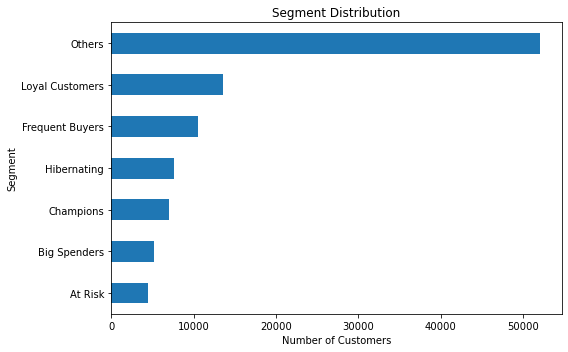

In [26]:
import matplotlib.pyplot as plt

segment_summary['Count'].sort_values().plot(kind='barh', figsize=(8, 5), title='Segment Distribution')
plt.xlabel('Number of Customers')
plt.tight_layout()
plt.show()


In [52]:
segment_descriptions = pd.DataFrame({
    'Segment': ['Champions', 'Loyal Customers', 'Frequent Buyers', 'Big Spenders', 'At Risk', 'Hibernating', 'Others'],
    'Description': [
        'Recent, frequent, and high-spending customers',
        'Regular customers who buy often',
        'Visit frequently but spend moderately',
        'Spend a lot but come less often',
        'Previously active but now silent',
        'Haven’t purchased in a long time',
        'Unremarkable — not recent, frequent, or big spenders'
    ]
})

segment_descriptions.to_csv("../outputs/segment_descriptions.csv", index=False)

## Segment Transitions

In [29]:
rfm_monthly = rfm_monthly.sort_values(by=['Customer ID', 'yearmonth'])

In [32]:
rfm_monthly['PrevSegment'] = rfm_monthly.groupby('Customer ID')['Segment'].shift(1)

In [34]:
rfm_monthly['SegmentTransition'] = rfm_monthly['PrevSegment'] + ' → ' + rfm_monthly['Segment']

In [35]:
rfm_monthly['SegmentTransition'] = rfm_monthly['SegmentTransition'].fillna('New → ' + rfm_monthly['Segment'])

In [40]:
outputs_path = r"C:\Users\DELL\Desktop\Kariyer\Upwork\Customer_Segmentation_Analytics\outputs\segment_transitions.csv"

In [ ]:
transitions = rfm_monthly[['Customer ID', 'yearmonth', 'PrevSegment', 'Segment', 'SegmentTransition']]

In [46]:
transitions['Customer ID'] = transitions['Customer ID'].astype(int)

<ipython-input-46-b5daf550ee67>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transitions['Customer ID'] = transitions['Customer ID'].astype(int)


In [47]:
transitions.to_csv(outputs_path, index=False, encoding='utf-8')